In [2]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import treeswift as ts
from Bio import SeqIO, Seq, motifs
import re
import logomaker
from collections import defaultdict
import numpy as np
from os.path import exists

In [3]:
taxdict = {}
taxonomy_tree = ts.read_tree_newick('../data/metazoan_taxonomy.nwk')
tax_groups = ['Ctenophora', 
             'Hemichordata', 
             'Bryozoa', 
             'Rotifera', 
             'Chordata', 
             'Echinodermata', 
             'Arthropoda', 
             'Mollusca', 
             'Annelida', 
             'Nematoda', 
             'Platyhelminthes',
             'Cnidaria']

for tax in ['Aves',
            'Mammalia',
            'Actinopteri',
            'Arthropoda',
            'Insecta',
            'Mollusca',
            'Nematoda']:
    for node in taxonomy_tree.root.traverse_bfs():
        if node[0].label.strip("'") == tax:
            for i in node[0].traverse_leaves():
                taxdict[i.label.strip("'").replace(' ', '_')] = tax 
                

metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
sample_df = metadata_df.loc[metadata_df.assembly_status == 'Chromosome'] \
                         .groupby('genus') \
                         .sample(1) \
                         .groupby('taxonomy') \
                         .sample(5) \
                         .reset_index()
print(metadata_df.head())

                 species  scaffold_n50 assembly_status         genus taxonomy
0     Abisara_bifasciata           464          Contig       Abisara    Other
1   Abrostola_tripartita      13645312      Chromosome     Abrostola  Insecta
2  Abscondita_terminalis       1220005        Scaffold    Abscondita  Insecta
3     Acanthaster_planci       1521119        Scaffold   Acanthaster    Other
4   Acanthisitta_chloris         64469        Scaffold  Acanthisitta     Aves


In [4]:
znf_counts = []
for species in sample_df.iterrows():
    try:
        znf_bed = pbt.BedTool(f'../data/beds/{species[1].species}_znfs.bed')
    except:
        print(f'{species} missing')
    for row in znf_bed:
        znf_counts.append((species[1].species, species[1].taxonomy, int(row[4])))
znf_count_df = pd.DataFrame(znf_counts, columns=['species', 'taxonomy', 'znf_count'])
print(znf_count_df)

                      species     taxonomy  znf_count
0      Plectropomus_leopardus  Actinopteri         20
1      Plectropomus_leopardus  Actinopteri          9
2      Plectropomus_leopardus  Actinopteri          5
3      Plectropomus_leopardus  Actinopteri         17
4      Plectropomus_leopardus  Actinopteri         10
...                       ...          ...        ...
15992   Rhinatrema_bivittatum        Other         15
15993   Rhinatrema_bivittatum        Other         18
15994   Rhinatrema_bivittatum        Other         34
15995   Rhinatrema_bivittatum        Other         23
15996   Rhinatrema_bivittatum        Other         24

[15997 rows x 3 columns]


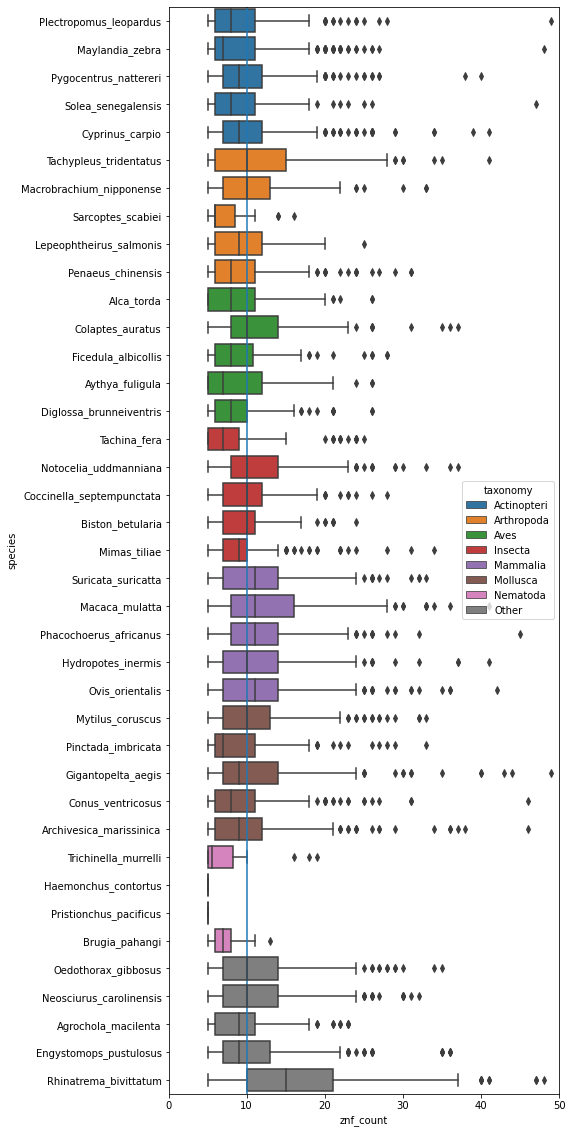

In [5]:
fig, ax = plt.subplots(figsize=(7, 20))
sns.boxplot(data=znf_count_df, y='species', x='znf_count', hue='taxonomy', ax=ax, dodge=False)
# ax.set_xscale('log')
ax.set_xlim(0, 50)
ax.axvline(znf_count_df.znf_count.median())
plt.show()

In [6]:
def extract_znf(species):
    znfs = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        znfs += re.findall('C..C.{12}H...H', str(record.seq.translate()))
    return znfs

def extract_footprints(species):
    footprints = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        footprints += re.findall('C..C.{12}H...H', str(record.seq.translate()))
    footprints = [f'{i[9]}{i[11]}{i[12]}{i[15]}' for i in footprints]
    return footprints

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

/Users/jonwells/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


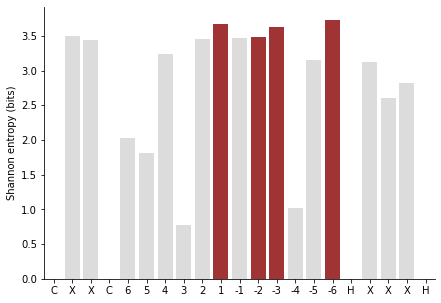

In [56]:
znfs = []
for row in metadata_df.loc[metadata_df.taxonomy == 'Actinopteri'].iterrows():
    if row[1].scaffold_n50 >= 10000:
        znfs += extract_znf(row[1].species)
mat_df = logomaker.alignment_to_matrix(znfs, to_type='probability').T
data = defaultdict(list)
for col in mat_df.columns:
    data['position'].append(col)
    data['entropy'].append(entropy(mat_df[col]))
    
znf_df = pd.DataFrame(data)
znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                     'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick',
                     'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'gainsboro', 'firebrick',
                     'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours)
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy (bits)')
ax.set_xticklabels(znf_df.pos_labels)
sns.despine()
plt.show()



In [59]:
with open('/Users/jonwells/Desktop/danio_rerio_motifs_shuffled_full.fa', 'w') as outfile:
    with open('/Users/jonwells/Desktop/danio_rerio_pfm.txt') as handle:
        for m in motifs.parse(handle, 'ClusterBuster'):
            cons = m.consensus
            if len(cons) < 12:
                continue
            cons = [c for c in cons]
            np.random.shuffle(cons)
            cons = ''.join(cons)
            # cons = ''.join([np.random.choice(['C', 'G']*36 + ['A', 'T']*64) for i in range(12)])
            # windows = set()
            # for i in range(len(cons) - 11):
            #     windows.add(cons[i:i+12])
            # for i, val in enumerate(windows):
            outfile.write(f'>{m.name}\n{cons}\n')

In [10]:
fp_freq = defaultdict(int)
all_fps = extract_footprints('Danio_rerio')
for fp in all_fps:
    fp_freq[fp] += 1
print(fp_freq)

defaultdict(<class 'int'>, {'RAAG': 1, 'NAER': 2, 'TNKE': 1, 'HFVR': 1, 'QGTL': 3, 'QSSR': 46, 'DSNK': 7, 'QSNT': 4, 'RCDA': 1, 'YFEV': 1, 'RSNQ': 74, 'RTNV': 2, 'QCNV': 1, 'RWNL': 1, 'RDIV': 1, 'RDHS': 3, 'NSAN': 2, 'SRGR': 1, 'YFTK': 1, 'AADT': 1, 'HVAM': 1, 'DGNR': 4, 'AQKT': 1, 'QGQT': 1, 'SQSS': 1, 'QGYR': 2, 'VQSS': 4, 'AQCS': 1, 'HQSR': 1, 'VQNS': 1, 'VHKY': 1, 'LNHR': 1, 'MQSS': 1, 'LQST': 1, 'VQNV': 2, 'QGQR': 1, 'EHNI': 1, 'KGNK': 1, 'TKEV': 1, 'SGNT': 2, 'TQSV': 1, 'DSHT': 1, 'QICS': 1, 'QAHR': 3, 'DAHV': 1, 'QTNK': 1, 'RDVI': 1, 'YGGT': 1, 'CSYI': 5, 'TQEL': 4, 'LNQV': 2, 'TGNA': 20, 'HPHN': 1, 'NTSS': 1, 'QSAS': 8, 'IAQY': 1, 'KGIN': 1, 'RDVT': 5, 'YGSS': 7, 'SRDV': 1, 'TEEL': 4, 'TSSI': 2, 'TANV': 3, 'HSQN': 1, 'KGTS': 2, 'YPST': 1, 'TKQY': 1, 'QGIN': 1, 'YSYN': 2, 'TNSS': 2, 'MANV': 1, 'TTEC': 1, 'KTIN': 1, 'LKEV': 1, 'TASV': 1, 'TTAY': 1, 'KAIN': 1, 'RGVT': 1, 'YSFA': 1, 'TKER': 1, 'LWQA': 1, 'HSHK': 19, 'TSSS': 2, 'TTHA': 1, 'KIIN': 1, 'SSKI': 106, 'TYNR': 1, 'EYLA': 1